In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../../../utils/')
import src_utils
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy

# 1. Set rcParams

In [187]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# 2. Set up grid

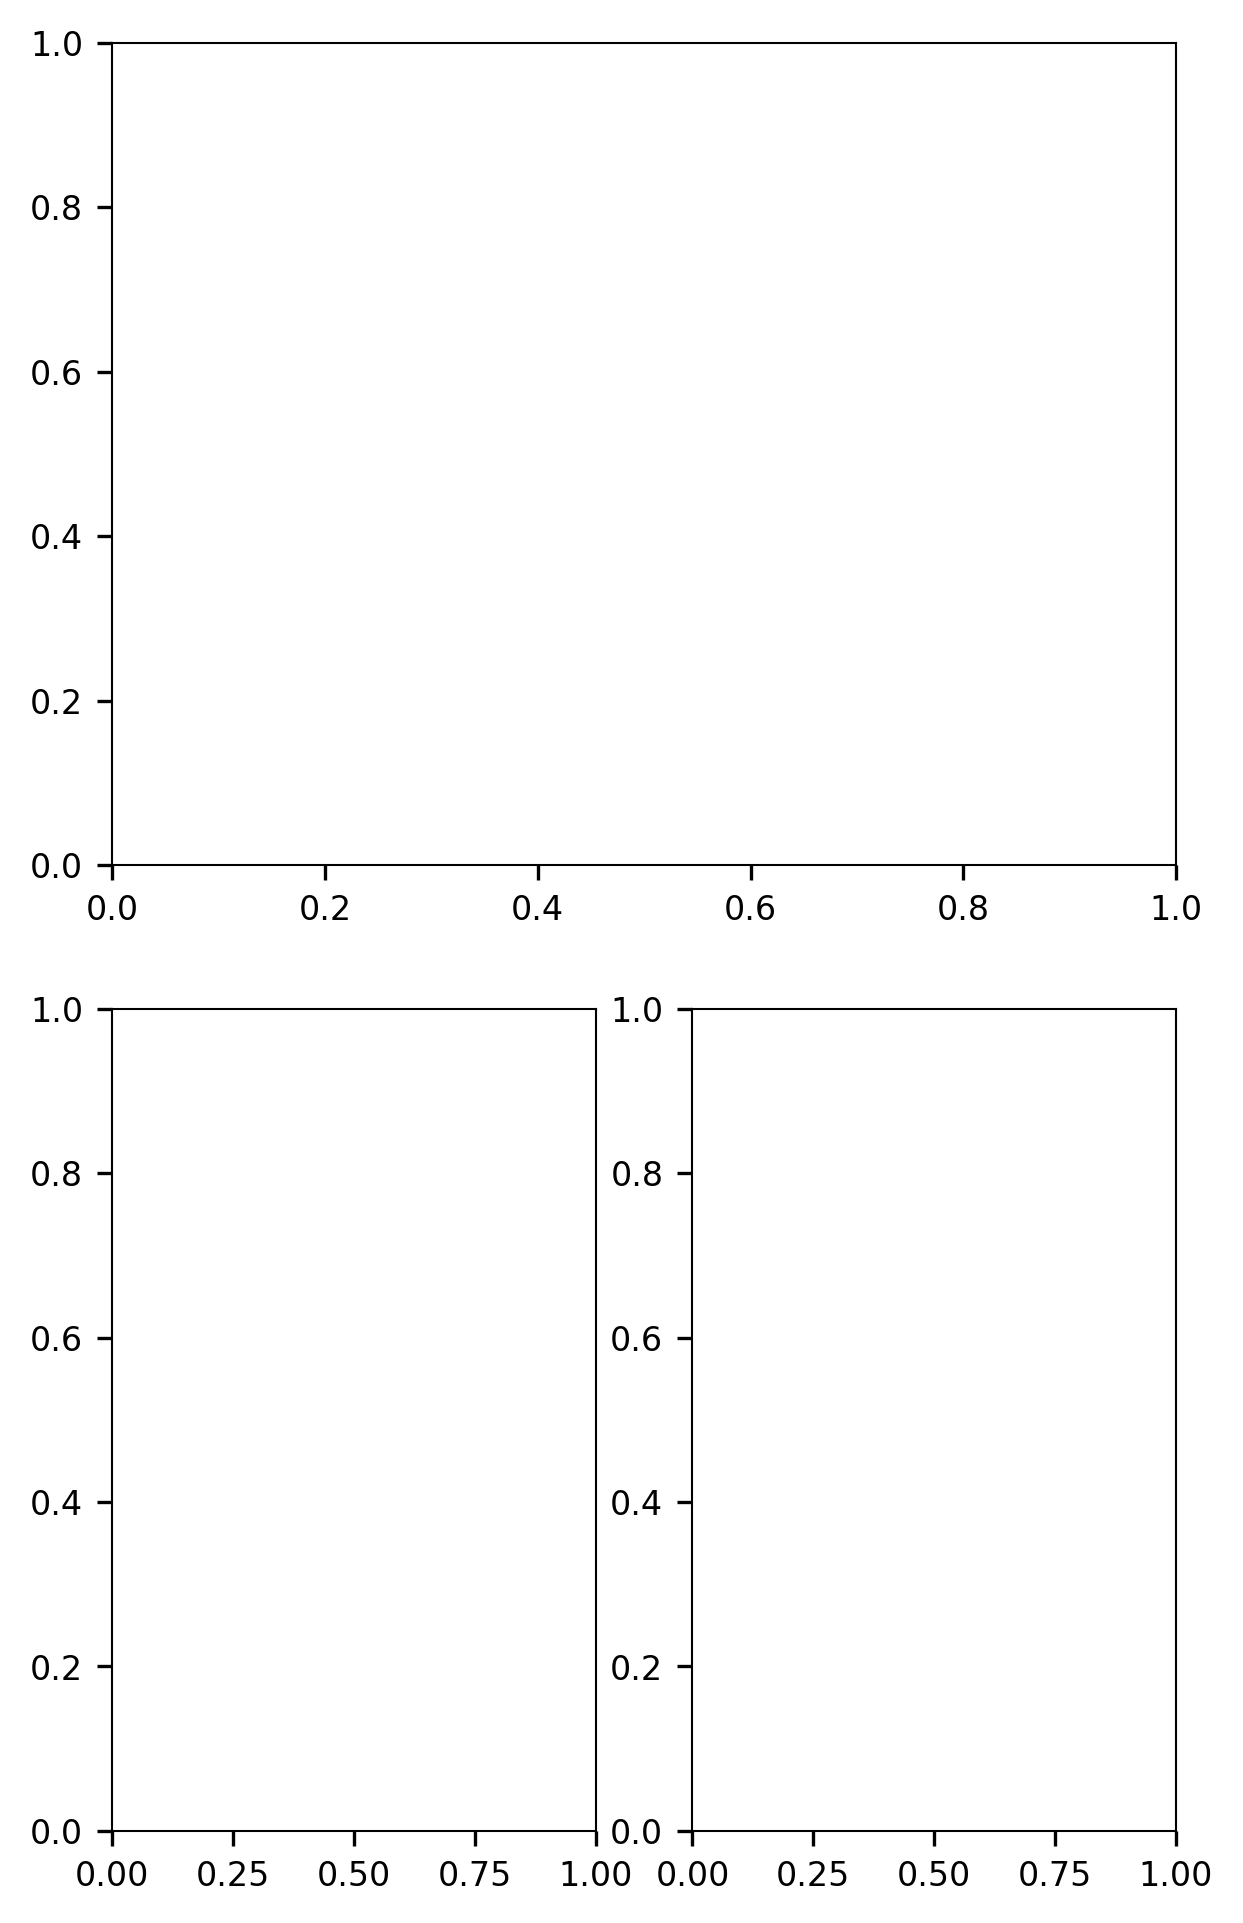

In [188]:
width = 114 / 25.4
height = 174 / 25.4
fig4 = plt.figure(constrained_layout=False, figsize=(width, height))
gs1 = fig4.add_gridspec(2, 2, left=0.16, right=0.95, top=0.95, bottom=0.55, hspace=0.05)
gs2 = fig4.add_gridspec(1, 2, left=0.16, right=0.95, top=0.48, bottom=0.08)

#f4_ax1 = fig4.add_subplot(gs1[0, :])
f4_ax2 = fig4.add_subplot(gs1[:2, :])
f4_ax3 = fig4.add_subplot(gs2[0, 0])
f4_ax4 = fig4.add_subplot(gs2[0, 1])


# Read in necessary data

In [189]:
# All residual values
resid_map = pd.read_csv('../../heatmaps/raw_resid_heatmap.csv', index_col=0)

# Client masks
client_mask = np.loadtxt('../../../utils/analysis_utils/client_mask.csv').astype(bool)
strong_client_mask = np.loadtxt('../../../utils/analysis_utils/strong_client_mask.csv').astype(bool)
ihb_client_mask = np.loadtxt('../../../utils/analysis_utils/inhibited_clients.csv').astype(bool)
dep_client_mask = np.loadtxt('../../../utils/analysis_utils/dependent_clients.csv').astype(bool)

# A. Windowed average

In [190]:
# Calculate moving average of client scores
def moving_average(a, n=10) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

pos_resid_ave = resid_map.mean(axis=1, skipna=True).values
windowed_resids = moving_average(pos_resid_ave)

f4_ax1.plot(np.linspace(270, 520, num=len(windowed_resids)), windowed_resids, c='k')
f4_ax1.set_ylabel('Average client\nscore')
f4_ax1.spines['top'].set_visible(False)
f4_ax1.spines['right'].set_visible(False)

# Delete tick labels
f4_ax1.get_xaxis().set_ticks([])

[]

# B. Inhibited vs dependent clients by position

In [191]:
# Get number of inhibited and dependent
num_dep = np.sum(dep_client_mask * 1, axis=1)
num_ihb = np.sum(ihb_client_mask * 1, axis=1)
num_mut = np.sum(~np.isnan(resid_map.values), axis=1)

# Calculate percentage
perc_dep = 100 * (num_dep / num_mut)
perc_ihb = 100 * (num_ihb / num_mut)

cmap = matplotlib.cm.get_cmap('bwr')
dep = cmap(0.3)
ihb = cmap(0.8)

pos_arr = np.arange(270, 520)
f4_ax2.bar(pos_arr, perc_dep, color=dep, label='Dependent clients')
f4_ax2.bar(pos_arr, perc_ihb, color=ihb, bottom=perc_dep, label='Inhibited clients')
f4_ax2.set_xlabel('Position')
f4_ax2.set_ylabel('Percent client\nvariants')
f4_ax2.legend(loc=2)
f4_ax2.spines['top'].set_visible(False)
f4_ax2.spines['right'].set_visible(False)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


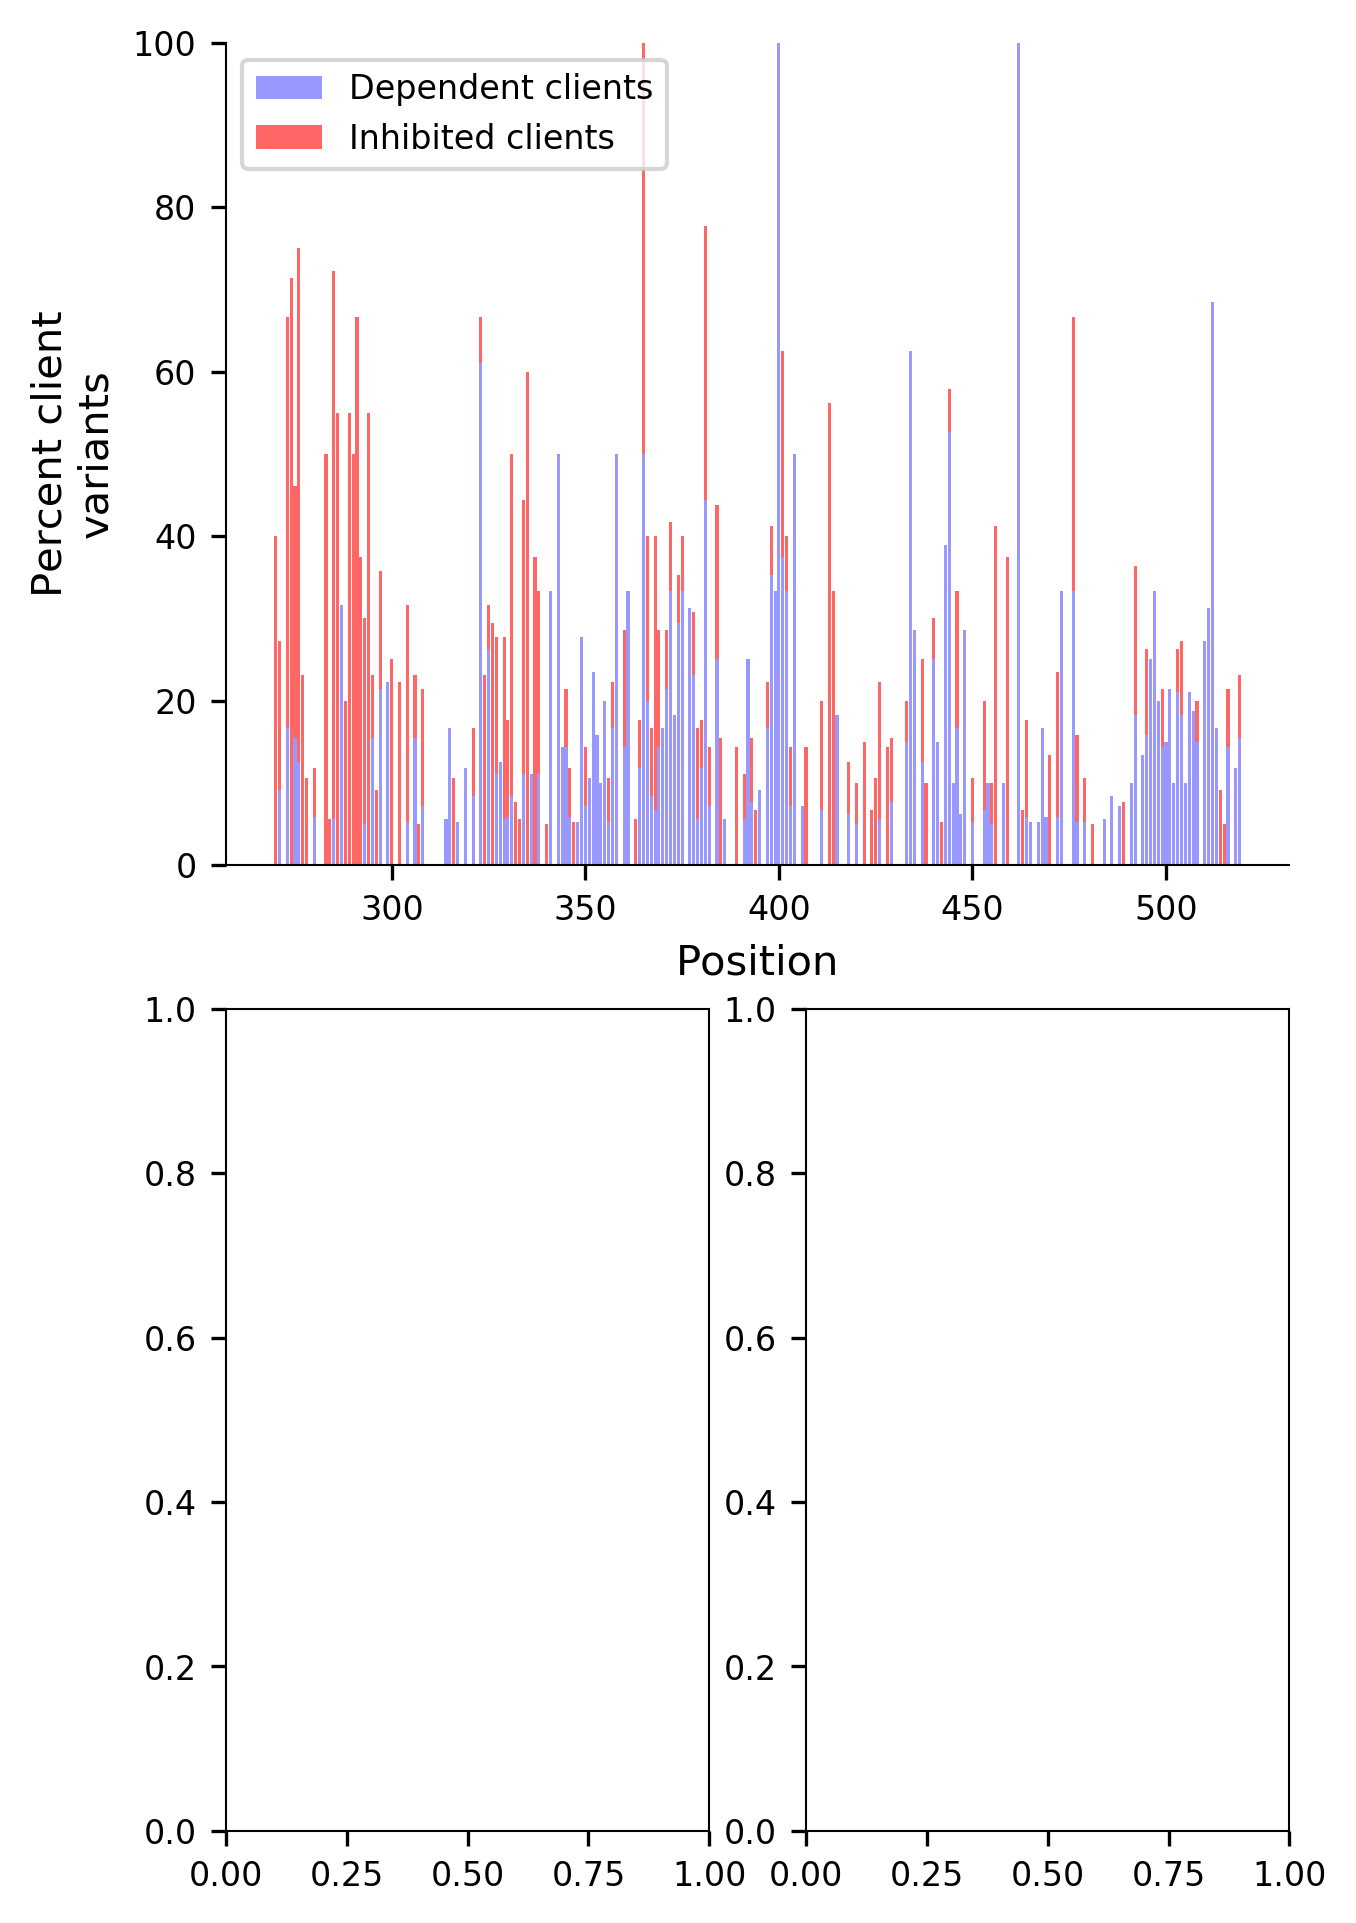

In [192]:
fig4

# D. Difference from median score

In [193]:
# Types of mutants in clients
client_med_aa = np.nanmedian(resid_map.values, axis=0)

# Dictionary for ticks
inv_aa_idx_dict = {v: k for k, v in src_utils.__aa_idx_dict__.items()}

# Set tick labels and locations
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()

# Plot bars
f4_ax3.barh(y_pos[:-1], client_med_aa[:-1], align='center', color='lightgrey')
f4_ax3.axvline(0, c='k')

# Relabel ticks
f4_ax3.set_yticks(y_pos[:-1])
f4_ax3.set_yticklabels(list(tick_labels)[:-1])
f4_ax3.set_xticks([-0.046, 0, 0.046])
f4_ax3.set_xticklabels([-0.03, 0, 0.03])
f4_ax3.invert_yaxis()  # labels read top-to-bottom

# Label axes
f4_ax3.set_xlabel('Median effect')
f4_ax3.set_ylabel('Amino acid')

Text(126.825, 0.5, 'Amino acid')

In [194]:
# Permutation test
from numpy.random import shuffle

num_muts = np.sum(~np.isnan(resid_map.values), axis=0)
num_dep = np.sum(dep_client_mask * 1, axis=0)
num_ihb = np.sum(ihb_client_mask * 1, axis=0)

t = abs(num_ihb - num_dep)

dep_copy = dep_client_mask.copy()
ihb_copy = ihb_client_mask.copy()

n_iter = 100000
results = np.zeros((21, n_iter))
for idx in np.arange(n_iter):
    # Flatten both
    dep_copy = dep_copy.flatten()
    ihb_copy = ihb_copy.flatten()
    
    # Shuffle as a 1D array
    shuffle(dep_copy)
    shuffle(ihb_copy)
    
    # Reshape into the right shape
    dep_copy = np.reshape(dep_copy, (250, 21))
    ihb_copy = np.reshape(ihb_copy, (250, 21))
    
    num_dep = np.sum(dep_copy * 1, axis=0)
    num_ihb = np.sum(ihb_copy * 1, axis=0)
    
    #perc_dep = 100 * (num_dep / num_muts)
    #perc_ihb = 100 * (num_ihb / num_muts)
    
    results[:, idx] = abs(num_ihb - num_dep)

# Calculate how many are above the threshold
n_over_t = np.zeros(21)

for idx in np.arange(len(n_over_t)):
    
    row = results[idx, :]
    count = sum(row > t[idx])
    n_over_t[idx] = count
    
n_over_t = (1.0 * n_over_t) / (1.0 * n_iter)

alpha = 0.05
sig_aas = n_over_t < alpha

pos = []
for idx, sig in enumerate(sig_aas):
    if sig:
        pos.append(idx)

In [195]:
# Plot percent of amino acid mutations that are clients
ax = f4_ax4
num_muts = np.sum(~np.isnan(resid_map.values), axis=0)
num_dep = np.sum(dep_client_mask * 1, axis=0)
num_ihb = np.sum(ihb_client_mask * 1, axis=0)

perc_dep = 100 * (num_dep / num_muts)
perc_ihb = 100 * (num_ihb / num_muts)

# set height of bar
diff = perc_ihb - perc_dep

# Set bar width
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(y_pos[:-1]))
r2 = [x + barWidth for x in r1]

# Set color
color_bars = []
for val in diff:
    if val > 0:
        color_bars.append(ihb)
    else:
        color_bars.append(dep)

# Plot bars
#fig, ax = plt.subplots()
ax.barh(r1, perc_dep[:-1], height=barWidth, color=dep)
ax.barh(r2, perc_ihb[:-1], height=barWidth, color=ihb)
#ax.barh(y_pos[:-1], perc_ihb[:-1], left=perc_dep[:-1], color=ihb)
#ax.axvline(0, c='k')
 

# Relabel ticks
ax.set_yticks(y_pos[:-1])
ax.set_yticklabels(list(tick_labels)[:-1])
ax.invert_yaxis()  # labels read top-to-bottom

#ax.set_xlim([-9, 9])

# Label axes
ax.set_xlabel('Percent client variants') 

ax.scatter([17.5] * len(pos), pos, marker=(6, 2, 0), c='k', linewidth=1)

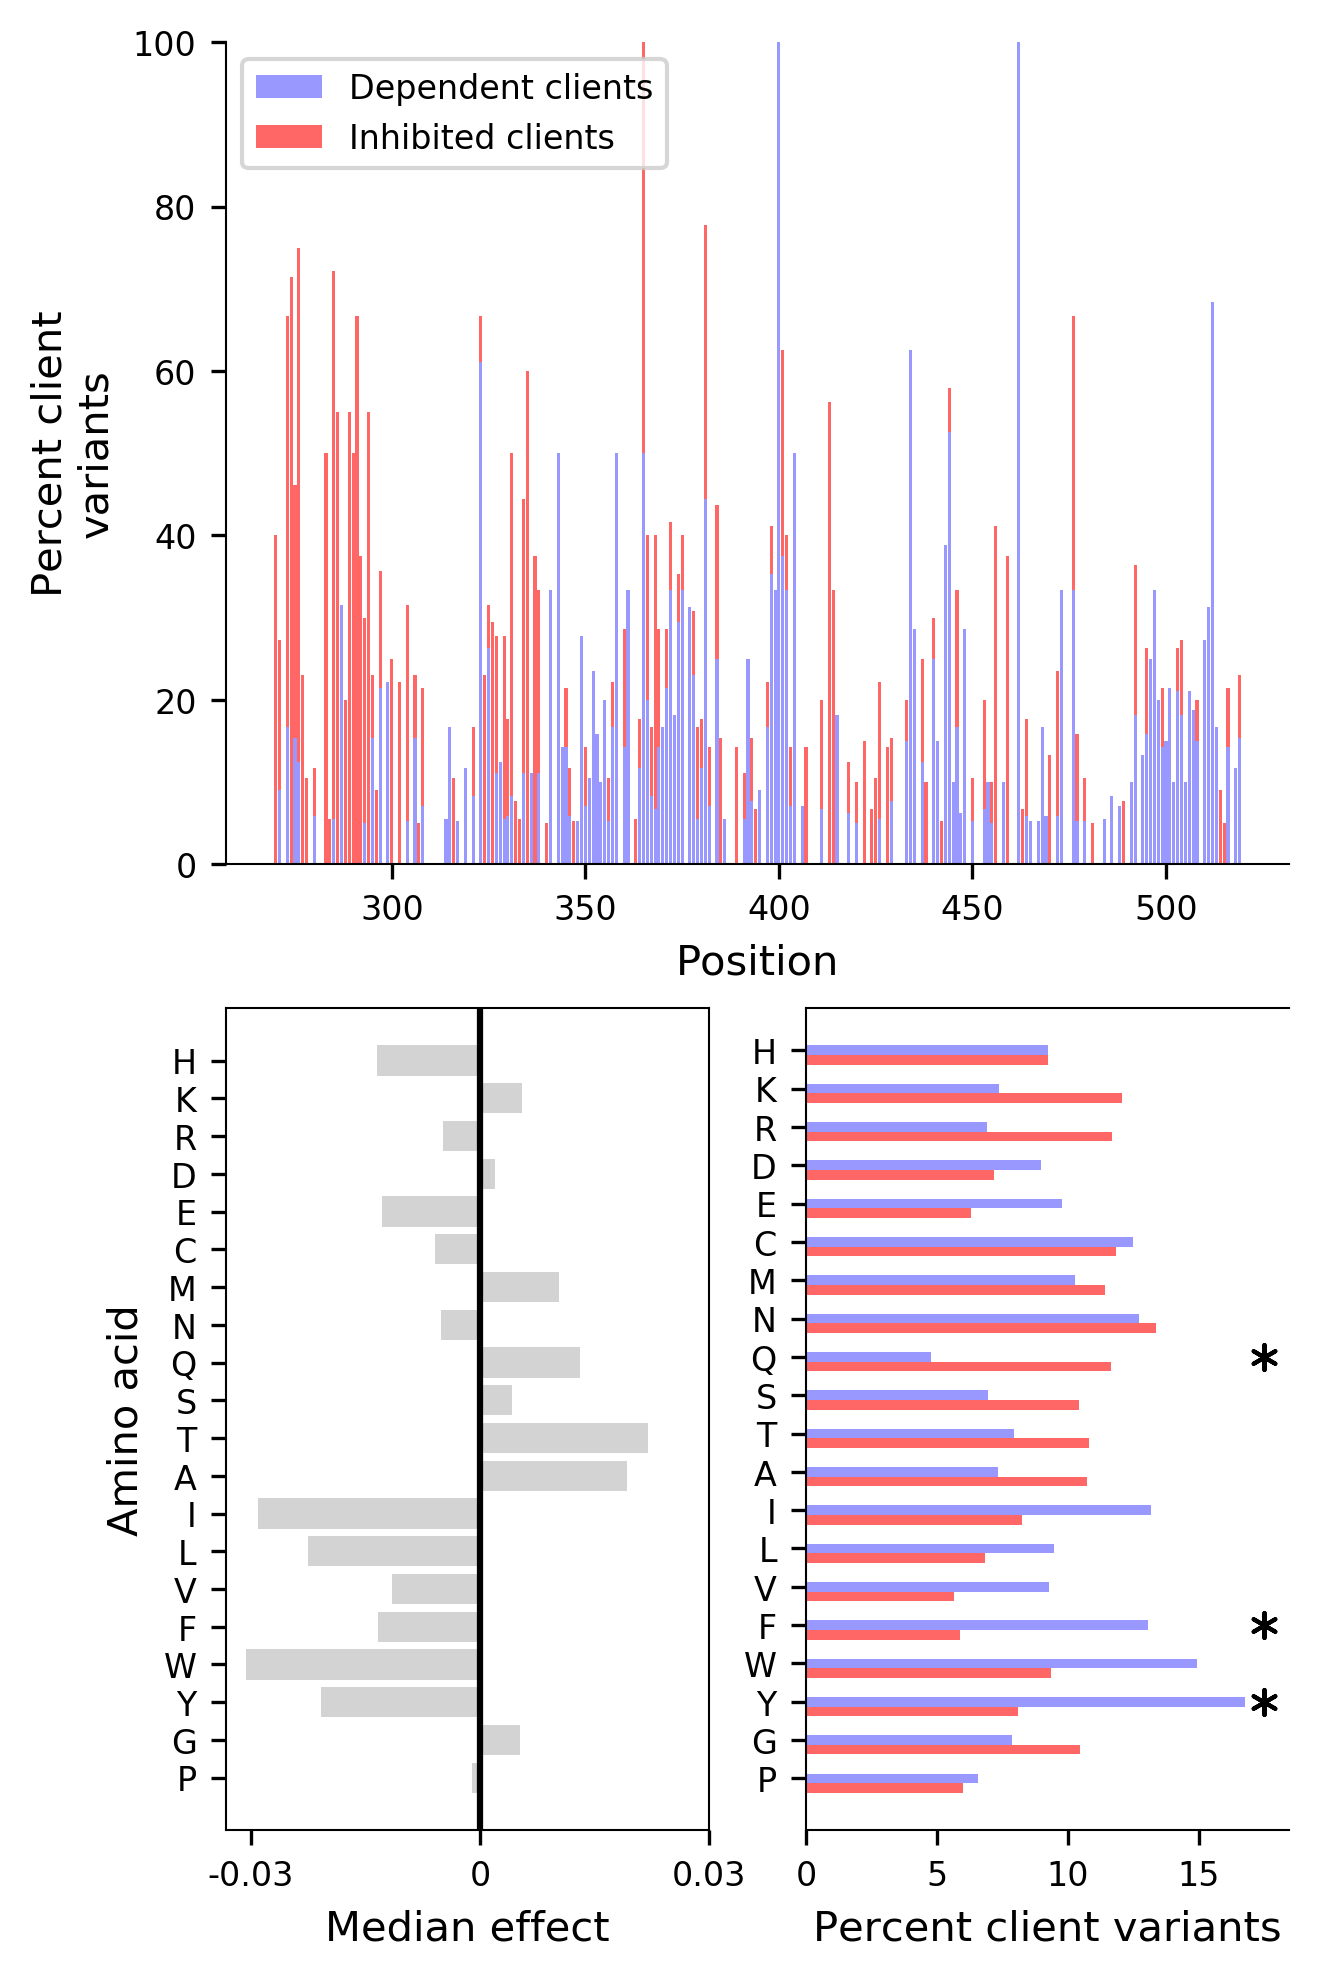

In [201]:
fig4

In [199]:
fig4.savefig('../../../Figures/manuscript_figs/fig4_drafts/f4_v3.png')